## Processing the data

In [2]:
import os.path
from matplotlib import pyplot as plt 
import numpy as np  

In [3]:
count_array = []

#Plotting the histogram of count for each entry (i.e. for each user,song pair avaulable in the dataset)
path = os.getcwd()
with open(os.path.dirname(path) + '/Data/year1_triplets_visible.txt','r') as f:
    for line in f:
        user, song, count = line.split()
        count = int(count)
        count_array.append(count)

Text(0.5, 1.0, 'Count Histogram')

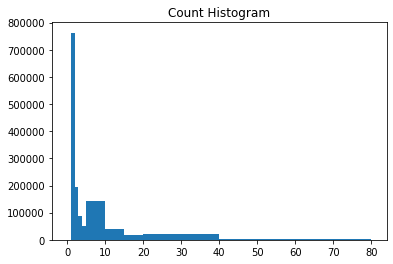

In [4]:
#Plotting the histogram to get an idea about the distribution of the count values
plt.hist(count_array,bins=[0,1,2,3,4,5,10,15,20,40,60,80]) 
  
plt.title("Count Histogram") 

In [24]:
#From above histogram we have created different class of count values.
#Because we have implecit data
#We don't have user rattings for song. So, we focused on the user behaviour.
#We can have a higher confidence on the song if user has listened to it more than once.


#userToSongCount is a dictionary 
#Where key is the user and value is an array of pairs of song and count
train_userToSongCount = dict()

#songToUserCount is a dictionary
#Where key is the song and value is an array of pairs of user and count
train_songToUserCount = dict()

total_Entries = 0

with open(os.path.dirname(path) + '/Data/year1_triplets_visible.txt','r') as f:
    for line in f:
        user, song, count = line.split()
        total_Entries += 1
        count = int(count)
        if(count>=3):
            if(count<=5):
                count = 3
            elif(count<=10):
                count = 4
            elif(count<=40):
                count = 5
            else:
                count = 6
                
        if user in train_userToSongCount:
            train_userToSongCount[user].append((song,count))
        else:
            train_userToSongCount[user] = [(song,count)]

        if song in train_songToUserCount:
            train_songToUserCount[song].append((user,count))
        else:
            train_songToUserCount[song] = [(user,count)]

#songs is a list of all different songs in the dataset
songs = sorted(train_songToUserCount.keys())
#users is a list of all different users in the dataset
users = sorted(train_userToSongCount.keys())

#songsToIndex maps each song to its index in the songs list
songsToIndex = dict()

#usersToIndex maps each user to its index in the users list
usersToIndex = dict()

for n, song in enumerate(songs, start=0):
    songsToIndex[song] = n

for n, user in enumerate(users, start=0):
    usersToIndex[user] = n

totalSongs = len(songs)
totalUsers = len(users)

In [25]:
print("Total users in Train Data:", totalUsers)
print("Total songs in Train Data:", totalSongs)
print("Total entries in Train Data:", total_Entries)

Total users in Train Data: 100000
Total songs in Train Data: 157251
Total entries in Train Data: 1319894


In [26]:
#Now reading the test data

#test_data is dictonary where key is the (user,song) pair and value is count(rating)
test_data = dict()

with open(os.path.dirname(path) + '/Data/year1_triplets_hidden.txt','r') as f:
    for line in f:
        user, song, count = line.split()
        total_Entries += 1
        count = int(count)
        if(count>=3):
            if(count<=5):
                count = 3
            elif(count<=10):
                count = 4
            elif(count<=40):
                count = 5
            else:
                count = 6
        test_data[(user,song)] = count

In [78]:
testing_users = []

with open(os.path.dirname(path) + '/Data/testing_500_users_sorted.txt','r') as f:
    for line in f:
        testing_users.append(line.strip())

In [28]:
#number of latent factors we are considering
no_features = 7

## Simple Factorisation Algorithm

In [29]:
song_averages = {}
user_offsets_averages = {}

# Calculate average song play count
# for given song average is sum of total play counts of that songs / number of users listened that song
for song in songs:
    song_averages[song] = sum(map(lambda x: x[1], train_songToUserCount[song])) / len(train_songToUserCount[song])


# Calculate average user offset
# Offset of given song and user = song play count for that user - average song play count of that song
# Average offset of a user = sum of offsets of all songs he/she plays / number of songs he/she plays
for user in users:
    user_offsets_averages[user] = sum(map(lambda x: (x[1] - song_averages[x[0]]), train_userToSongCount[user])) / len(train_userToSongCount[user])

# Function to calculate baseline prediction
def baseline_prediction(user, song):
    return song_averages[song] + user_offsets_averages[user]

In [55]:
# For user_feature Matrix
rows = no_features
cols = totalUsers

# Initializing user_feature matrix
user_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

# For song_feature Matrix
rows = no_features
cols = totalSongs

# Initializing song_feature matrix
song_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

In [56]:
LearningRate = 0.01

In [57]:
# To get prediction for a user and a song
# We are calculating the dot product of user_feature of that user and song_feature of that song

def prediction(user, song):
    predicted_count = 0
    for i in range(no_features):
        predicted_count += user_feature[i][usersToIndex[user]] * song_feature[i][songsToIndex[song]]
    return predicted_count

In [58]:
#Simple train function
def train(user, song, count, feature_index, baseline):
    err = 0
    if(baseline):
        err = count - baseline_prediction(user, song)
    else:
        err = count - prediction(user, song)
        
    uv = user_feature[feature_index][usersToIndex[user]]
    sv = song_feature[feature_index][songsToIndex[song]]
    
    user_feature[feature_index][usersToIndex[user]] += LearningRate * err * sv
    song_feature[feature_index][songsToIndex[song]] += LearningRate * err * uv

    return err

In [ ]:
#Now, we train each feature over whole train data
#In first iteration we use baseline prediction (which is sum of average of song play count and average user offset)
for feature in range(no_features):
    err = 0

    for user in train_userToSongCount:
        for song in train_userToSongCount[user]:
            temp = abs(train(user, song[0], song[1], feature, True))
            if(temp != temp):
                print("temp ",temp)
                break
            err += temp
    
    avg_err = err / total_Entries

In [60]:
#Calculating RMSE and MAE for test data

def test():
    absolute_error = 0
    mean_square_error = 0

    for (user,song) in test_data:
        if(user not in train_userToSongCount or song not in train_songToUserCount):
            continue
        absolute_error += abs(prediction(user,song) - test_data[(user,song)])
        mean_square_error += ( (prediction(user,song) - test_data[(user,song)])**2)

    absolute_error = absolute_error/len(test_data)
    mean_square_error = mean_square_error/len(test_data)
    rmse = (mean_square_error)**0.5

    return rmse, absolute_error

In [61]:
train_mae_each_iteration = []
test_mae_each_iteration = []
train_rmse_each_iteration = []
test_rmse_each_iteration = []


In [123]:
iteration = 45

#Now iterate over train data and train each feature
while(iteration < 50):
    print("Iteration:", iteration)
    for feature in range(no_features):
        err = 0
        rmse = 0
        #Training each feature for each entry in train data
        for user in train_userToSongCount:
            for song in train_userToSongCount[user]:
                temp = abs(train(user, song[0], song[1],feature,False))
                err += temp
                rmse += temp*temp

        #Calculating RMSE and MAE for train data
        avg_err = err / total_Entries
        rmse = (rmse/total_Entries)**(0.5)

        if(avg_err < 0.1):
            interation = 500
            break

    test_rmse,test_mae = test()

    #Appending RMSE and MAE for test data and train data
    train_mae_each_iteration.append(avg_err)
    train_rmse_each_iteration.append(rmse)
    test_mae_each_iteration.append(test_mae)
    test_rmse_each_iteration.append(test_rmse)
    print("Train_MAE =", avg_err,"  Train_RMSE =",rmse)
    print("Test_MAE =", test_mae,"  Test_RMSE =",test_rmse)    
    iteration += 1

Iteration: 45
Train_MAE = 0.25874967151588807   Train_RMSE = 0.5031847783627688
Test_MAE = 0.8484464464026678   Test_RMSE = 1.197614520726031
Iteration: 46
Train_MAE = 0.2561625472084806   Train_RMSE = 0.49846542666431165
Test_MAE = 0.8507574135395691   Test_RMSE = 1.2016038439771124
Iteration: 47
Train_MAE = 0.2536168516363435   Train_RMSE = 0.493813552612021
Test_MAE = 0.8530859515834681   Test_RMSE = 1.2055957026952215
Iteration: 48
Train_MAE = 0.25111280575168593   Train_RMSE = 0.48922965857301975
Test_MAE = 0.8554255825836856   Test_RMSE = 1.209582761535723
Iteration: 49
Train_MAE = 0.24865317254811534   Train_RMSE = 0.48471410303309254
Test_MAE = 0.8577671774830696   Test_RMSE = 1.2135587070510787


In [65]:
import numpy as np
np.savetxt("user_feature.txt", user_feature)
np.savetxt("song_feature.txt", song_feature)

In [69]:
user_feature = np.loadtxt("user_feature.txt")
song_feature = np.loadtxt("song_feature.txt")

In [80]:
#recommendation is a dictionary of user to list of songs
recommendations = dict()
for user in testing_users:
    song_rating_dict = dict()
    for song in songs:
        song_rating_dict[song] = prediction(user,song)
    recommendation = sorted(song_rating_dict.items(), key=lambda item: item[1], reverse=True)[:30] #top 30 songs
    recommendations[user] = list(map(lambda x: x[0], recommendation)) 

In [95]:
import json
with open("factorization_recommendations.json", "w") as outfile:
    json.dump(recommendations, outfile)

In [96]:
import json
# Opening JSON file
with open('factorization_recommendations.json') as json_file:
    data = json.load(json_file)

## Condsidering the Regularization and non-Linear prediction function

In [81]:
# To get prediction for a user and a song
# We are calculating the dot product of user_feature of that user and song_feature of that song
# We know that ratngs are between 1 and 6 so we also use this
# That is why we are using 6 as max rating
def prediction_nonlinear(user, song):
    predicted_count = 0
    for i in range(no_features):
        predicted_count += min(regularised_user_feature[i][usersToIndex[user]] * regularised_song_feature[i][songsToIndex[song]],6)
    return min(predicted_count,6)

In [82]:
# For user_feature Matrix
rows = no_features
cols = totalUsers

# Initializing user_feature matrix
regularised_user_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

# For song_feature Matrix
rows = no_features
cols = totalSongs

# Initializing song_feature matrix
regularised_song_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

In [83]:
K = 0.05

In [85]:
#Regularised trian function
#Here K is regularisation constant
def train_regularization(user, song, count, feature_index, baseline):
    err = 0
    if(baseline):
        err = count - baseline_prediction(user, song)
    else:
        err = count - prediction_nonlinear(user, song)
        
    uv = regularised_user_feature[feature_index][usersToIndex[user]]
    sv = regularised_song_feature[feature_index][songsToIndex[song]]
    
    regularised_user_feature[feature_index][usersToIndex[user]] += LearningRate * (err*sv - K*uv)
    regularised_song_feature[feature_index][songsToIndex[song]] += LearningRate * (err*uv - K*sv)

    return err

In [86]:
#Now, we train each feature over whole train data
#In first iteration we use baseline prediction (which is sum of average of song play count and average user offset)
for feature in range(no_features):
    err = 0

    for user in train_userToSongCount:
        for song in train_userToSongCount[user]:
            temp = abs(train_regularization(user, song[0], song[1], feature, True))
            if(temp != temp):
                print("temp ",temp)
                break
            err += temp
    
    avg_err = err / total_Entries

print("Error : ",avg_err)

Error :  0.3561994158715749


In [101]:
#Calculating RMSE and MAE for test data

def regularised_test():
    absolute_error = 0
    mean_square_error = 0

    for (user,song) in test_data:
        if(user not in train_userToSongCount or song not in train_songToUserCount):
            continue
        absolute_error += abs(prediction_nonlinear(user,song) - test_data[(user,song)])
        mean_square_error += ( (prediction_nonlinear(user,song) - test_data[(user,song)])**2)

    absolute_error = absolute_error/len(test_data)
    mean_square_error = mean_square_error/len(test_data)
    rmse = (mean_square_error)**0.5

    return rmse, absolute_error

In [102]:
regularised_train_mae_each_iteration = []
regularised_test_mae_each_iteration = []
regularised_train_rmse_each_iteration = []
regularised_test_rmse_each_iteration = []

In [124]:
iteration = 45

while(iteration < 50):
    print("Iteration:", iteration)
    for feature in range(no_features):
        err = 0
        for user in train_userToSongCount:
            for song in train_userToSongCount[user]:
                temp = abs(train_regularization(user, song[0], song[1],feature,False))
                rmse += temp*temp
                err += temp
        
        avg_err = err / total_Entries
        rmse = (rmse/total_Entries)**(0.5)

        if(avg_err < 0.1):
            interation = 500
            break

    test_rmse,test_mae = regularised_test()

    regularised_train_mae_each_iteration.append(avg_err)
    regularised_train_rmse_each_iteration.append(rmse)
    regularised_test_mae_each_iteration.append(test_mae)
    regularised_test_rmse_each_iteration.append(test_rmse)
    print("Train_MAE =", avg_err,"  Train_RMSE =",rmse)
    print("Test_MAE =", test_mae,"  Test_RMSE =",test_rmse) 
    iteration += 1

Iteration: 45
Train_MAE = 0.2982272848985   Train_RMSE = 0.5712331565043655
Test_MAE = 0.7996874462629181   Test_RMSE = 1.1143962077245577
Iteration: 46
Train_MAE = 0.2964232902356486   Train_RMSE = 0.5680937723845927
Test_MAE = 0.8002431666835995   Test_RMSE = 1.115594738041443
Iteration: 47
Train_MAE = 0.294632329665642   Train_RMSE = 0.5649772032310965
Test_MAE = 0.8008188978624923   Test_RMSE = 1.116825826209116
Iteration: 48
Train_MAE = 0.29285371852277636   Train_RMSE = 0.5618815973275025
Test_MAE = 0.8014163391672985   Test_RMSE = 1.1180864051303363
Iteration: 49
Train_MAE = 0.29108659144375165   Train_RMSE = 0.5588053103732314
Test_MAE = 0.8020322008189578   Test_RMSE = 1.1193737381124444


In [108]:
np.savetxt("regularised_user_feature.txt", regularised_user_feature)
np.savetxt("regularised_song_feature.txt", regularised_song_feature)

In [112]:
#recommendation is a dictionary of user to list of songs
recommendations_regularizaiton = dict()
for user in testing_users:
    song_rating_dict = dict()
    for song in songs:
        song_rating_dict[song] = prediction_nonlinear(user,song)
    recommendation = sorted(song_rating_dict.items(), key=lambda item: item[1], reverse=True)[:30] #top 30 songs
    recommendations_regularizaiton[user] = list(map(lambda x: x[0], recommendation)) 

In [113]:
import json
with open("factorization_recommendations_regularization.json", "w") as outfile:
    json.dump(recommendations_regularizaiton, outfile)

In [114]:
import json
# Opening JSON file
with open('factorization_recommendations_regularization.json') as json_file:
    data = json.load(json_file)

## Conclusion and Plotting of Results

In [130]:
print("Minimum test MAE = ",min(test_mae_each_iteration),"achieved at iteration : ",test_mae_each_iteration.index(min(test_mae_each_iteration))+1)
print("Minimum test RMSE = ",min(test_rmse_each_iteration),"achieved at iteration : ",test_rmse_each_iteration.index(min(test_rmse_each_iteration))+1)

print("Minimum test MAE(in Regularised version) = ",min(regularised_test_mae_each_iteration),"achieved at iteration : ",regularised_test_mae_each_iteration.index(min(regularised_test_mae_each_iteration))+1)
print("Minimum test RMSE(in Regularised version) = ",min(regularised_test_rmse_each_iteration),"achieved at iteration : ",regularised_test_rmse_each_iteration.index(min(regularised_test_rmse_each_iteration))+1)

Minimum test MAE =  0.8140255107576854 achieved at iteration :  23
Minimum test RMSE =  1.1336004633075791 achieved at iteration :  22
Minimum test MAE(in Regularised version) =  0.795276731087748 achieved at iteration :  32
Minimum test RMSE(in Regularised version) =  1.1032408552165143 achieved at iteration :  30


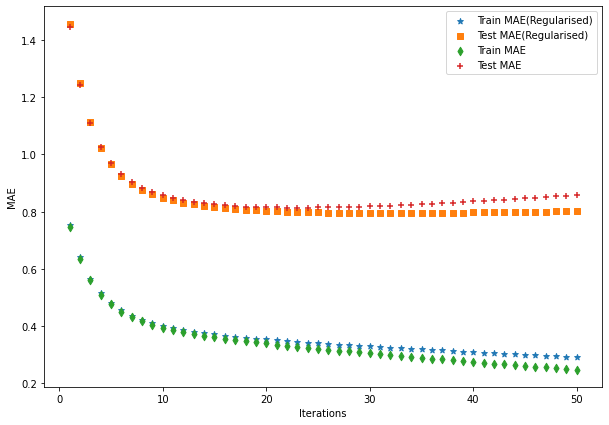

In [128]:
plt.figure(figsize=(10,7))
plt.scatter(range(1,51),regularised_train_mae_each_iteration,marker="*",label="Train MAE(Regularised)")
plt.scatter(range(1,51),regularised_test_mae_each_iteration,marker="s",label="Test MAE(Regularised)")
plt.scatter(range(1,51),train_mae_each_iteration,marker="d",label="Train MAE")
plt.scatter(range(1,51),test_mae_each_iteration,marker="+",label="Test MAE")
plt.xlabel("Iterations")
plt.ylabel("MAE")
plt.legend()
plt.show()



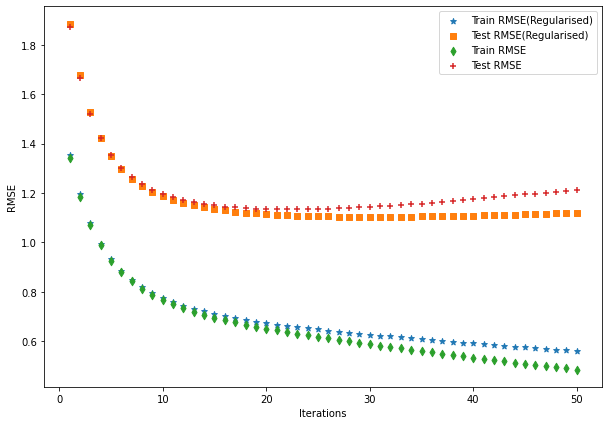

In [129]:
plt.figure(figsize=(10,7))
plt.scatter(range(1,51),regularised_train_rmse_each_iteration,marker="*",label="Train RMSE(Regularised)")
plt.scatter(range(1,51),regularised_test_rmse_each_iteration,marker="s",label="Test RMSE(Regularised)")
plt.scatter(range(1,51),train_rmse_each_iteration,marker="d",label="Train RMSE")
plt.scatter(range(1,51),test_rmse_each_iteration,marker="+",label="Test RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [127]:
import numpy as np

np.savetxt("regularised_train_mae_each_iteration.txt", regularised_train_mae_each_iteration)
np.savetxt("regularised_test_mae_each_iteration.txt", regularised_test_mae_each_iteration)
np.savetxt("regularised_train_rmse_each_iteration.txt", regularised_train_rmse_each_iteration)
np.savetxt("regularised_test_rmse_each_iteration.txt", regularised_test_rmse_each_iteration)

np.savetxt("train_mae_each_iteration.txt",train_mae_each_iteration)
np.savetxt("test_mae_each_iteration.txt",test_mae_each_iteration)
np.savetxt("train_rmse_each_iteration.txt",train_rmse_each_iteration)
np.savetxt("test_rmse_each_iteration.txt",test_rmse_each_iteration)

In [197]:
#regularised_train_mae_each_iteration = np.loadtxt("regularised_train_mae_each_iteration.txt")
#regularised_test_mae_each_iteration = np.loadtxt("regularised_test_mae_each_iteration.txt")
#regularised_train_rmse_each_iteration = np.loadtxt("regularised_train_rmse_each_iteration.txt")
#regularised_test_rmse_each_iteration = np.loadtxt("regularised_test_rmse_each_iteration.txt")